## 6 循环神经网络

$RNN$网络是一种基础的多层反馈神经网络，该神经网络的节点定向连接成环，其内部状态可以展示动态时序行为。相比于前馈神经网络，该网络内部具有很强的记忆性，它可以利用它内部的记忆来处理任意时序的输入序列，所以常用于做自然语言处理.

### 6.1 网络结构

我们从基础的神经网络中知道，神经网络包含输入层、隐层、输出层，通过激活函数控制输出，层与层之间通过权值连接。激活函数是事先确定好的，那么神经网络模型通过训练“学“到的东西就蕴含在“权值“中。
基础的神经网络只在层与层之间建立了权连接，RNN最大的不同之处就是在层之间的神经元之间也建立的权连接。如图
<img width='500px' src="https://doc.shiyanlou.com/document-uid245411labid7971timestamp1534844106676.png">


这是一个标准的RNN结构图，图中每个箭头代表做一次变换，也就是说箭头连接带有权值。左侧是折叠起来的样子，右侧是展开的样子，左侧中h旁边的箭头代表此结构中的“循环“体现在隐层。
在展开结构中我们可以观察到，在标准的RNN结构中，隐层的神经元之间也是带有权值的。也就是说，随着序列的不断推进，前面的隐层将会影响后面的隐层。图中O代表输出，y代表样本给出的确定值，L代表损失函数，我们可以看到，“损失“也是随着序列的推荐而不断积累的。
除上述特点之外，标准RNN的还有以下特点：
1、权值共享，图中的W全是相同的，U和V也一样。
2、每一个输入值都只与它本身的那条路线建立权连接，不会和别的神经元连接。

下图展示了如何基于循环神经网络实现语言模型。我们的目的是基于当前的输入与过去的输入序列，预测序列的下一个字符。循环神经网络引入一个隐藏变量$H$，用$H_{t}$表示$H$在时间步$t$的值。$H_{t}$的计算基于$X_{t}$和$H_{t-1}$，可以认为$H_{t}$记录了到当前字符为止的序列信息，利用$H_{t}$对序列的下一个字符进行预测。
![Image Name](https://cdn.kesci.com/upload/image/q5jkm0v44i.png?imageView2/0/w/640/h/640)

### 6.2 循环神经网络的构造

我们先看循环神经网络的具体构造。假设$\boldsymbol{X}_t \in \mathbb{R}^{n \times d}$是时间步$t$的小批量输入，$\boldsymbol{H}_t  \in \mathbb{R}^{n \times h}$是该时间步的隐藏变量，则：


$$
\boldsymbol{H}_t = \phi(\boldsymbol{X}_t \boldsymbol{W}_{xh} + \boldsymbol{H}_{t-1} \boldsymbol{W}_{hh}  + \boldsymbol{b}_h).
$$


其中，$\boldsymbol{W}_{xh} \in \mathbb{R}^{d \times h}$，$\boldsymbol{W}_{hh} \in \mathbb{R}^{h \times h}$，$\boldsymbol{b}_{h} \in \mathbb{R}^{1 \times h}$，$\phi$函数是非线性激活函数。由于引入了$\boldsymbol{H}_{t-1} \boldsymbol{W}_{hh}$，$H_{t}$能够捕捉截至当前时间步的序列的历史信息，就像是神经网络当前时间步的状态或记忆一样。由于$H_{t}$的计算基于$H_{t-1}$，上式的计算是循环的，使用循环计算的网络即循环神经网络（recurrent neural network）。

在时间步$t$，输出层的输出为：


$$
\boldsymbol{O}_t = \boldsymbol{H}_t \boldsymbol{W}_{hq} + \boldsymbol{b}_q.
$$


其中$\boldsymbol{W}_{hq} \in \mathbb{R}^{h \times q}$，$\boldsymbol{b}_q \in \mathbb{R}^{1 \times q}$。

|||
|-|-|
|$W_xh$|状态-输入权重 |
|$W_hh$|状态-状态权重|
|$W_hq$|状态-输出权重|
|$b_h$|隐藏层的偏置|
|$b_q$|输出层的偏置|

### 6.3 从零开始实现循环神经网络
使用周杰伦的歌词作为语料，从零开始实现一个基于字符级循环神经网络的语言模型

读入数据

In [2]:
import torch
import torch.nn as nn
import time
import math
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l
(corpus_indices, char_to_idx, idx_to_char, vocab_size) = d2l.load_data_jay_lyrics()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### one-hot向量

我们需要将字符表示成向量，这里采用one-hot向量。假设词典大小是$N$，每次字符对应一个从$0$到$N-1$的唯一的索引，则该字符的向量是一个长度为$N$的向量，若字符的索引是$i$，则该向量的第$i$个位置为$1$，其他位置为$0$。下面分别展示了索引为0和2的one-hot向量，向量长度等于词典大小。

In [5]:
def one_hot(x, n_class, dtype=torch.float32):
    result = torch.zeros(x.shape[0], n_class, dtype=dtype, device=x.device)  # shape: (n, n_class)
    result.scatter_(1, x.long().view(-1, 1), 1)  # result[i, x[i, 0]] = 1
    return result
    
x = torch.tensor([0, 2])
x_one_hot = one_hot(x, vocab_size)
print(x_one_hot)
print(x_one_hot.shape)
print(x_one_hot.sum(axis=1))

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])
torch.Size([2, 1027])
tensor([1., 1.])


我们每次采样的小批量的形状是（批量大小, 时间步数）。下面的函数将这样的小批量变换成数个形状为（批量大小, 词典大小）的矩阵，矩阵个数等于时间步数。也就是说，时间步$t$的输入为$\boldsymbol{X}_t \in \mathbb{R}^{n \times d}$，其中$n$为批量大小，$d$为词向量大小，即one-hot向量长度（词典大小）。

In [6]:
def to_onehot(X, n_class):
    return [one_hot(X[:, i], n_class) for i in range(X.shape[1])]

X = torch.arange(10).view(2, 5)
inputs = to_onehot(X, vocab_size)
print(len(inputs), inputs[0].shape)

5 torch.Size([2, 1027])


In [7]:
#初始化模型参数
num_inputs, num_hiddens, num_outputs = vocab_size, 256, vocab_size
# num_inputs: d
# num_hiddens: h, 隐藏单元的个数是超参数
# num_outputs: q

def get_params():
    def _one(shape):
        param = torch.zeros(shape, device=device, dtype=torch.float32)
        nn.init.normal_(param, 0, 0.01)
        return torch.nn.Parameter(param)

    # 隐藏层参数
    W_xh = _one((num_inputs, num_hiddens))
    W_hh = _one((num_hiddens, num_hiddens))
    b_h = torch.nn.Parameter(torch.zeros(num_hiddens, device=device))
    # 输出层参数
    W_hq = _one((num_hiddens, num_outputs))
    b_q = torch.nn.Parameter(torch.zeros(num_outputs, device=device))
    return (W_xh, W_hh, b_h, W_hq, b_q)

**定义模型**

函数`rnn`用循环的方式依次完成循环神经网络每个时间步的计算。

In [8]:
def rnn(inputs, state, params):
    # inputs和outputs皆为num_steps个形状为(batch_size, vocab_size)的矩阵
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.matmul(X, W_xh) + torch.matmul(H, W_hh) + b_h)
        Y = torch.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return outputs, (H,)

In [9]:
#函数init_rnn_state初始化隐藏变量，这里的返回值是一个元组。
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [11]:
#做个简单的测试来观察输出结果的个数（时间步数），以及第一个时间步的输出层输出的形状和隐藏状态的形状。
print(X.shape)
print(num_hiddens)
print(vocab_size)
state = init_rnn_state(X.shape[0], num_hiddens, device)
inputs = to_onehot(X.to(device), vocab_size)
params = get_params()
outputs, state_new = rnn(inputs, state, params)
print(len(inputs), inputs[0].shape)
print(len(outputs), outputs[0].shape)
print(len(state), state[0].shape)
print(len(state_new), state_new[0].shape)

torch.Size([2, 5])
256
1027
5 torch.Size([2, 1027])
5 torch.Size([2, 1027])
1 torch.Size([2, 256])
1 torch.Size([2, 256])


** 裁剪梯度**

循环神经网络中较容易出现梯度衰减或梯度爆炸，这会导致网络几乎无法训练。裁剪梯度（clip gradient）是一种应对梯度爆炸的方法。假设我们把所有模型参数的梯度拼接成一个向量 $\boldsymbol{g}$，并设裁剪的阈值是$\theta$。裁剪后的梯度


$$
 \min\left(\frac{\theta}{\|\boldsymbol{g}\|}, 1\right)\boldsymbol{g}
$$


的$L_2$范数不超过$\theta$。


In [12]:
def grad_clipping(params, theta, device):
    norm = torch.tensor([0.0], device=device)
    for param in params:
        norm += (param.grad.data ** 2).sum()
    norm = norm.sqrt().item()
    if norm > theta:
        for param in params:
            param.grad.data *= (theta / norm)

**定义预测函数**

以下函数基于前缀`prefix`（含有数个字符的字符串）来预测接下来的`num_chars`个字符。这个函数稍显复杂，其中我们将循环神经单元`rnn`设置成了函数参数，这样在后面小节介绍其他循环神经网络时能重复使用这个函数。


In [14]:
def predict_rnn(prefix, num_chars, rnn, params, init_rnn_state,
                num_hiddens, vocab_size, device, idx_to_char, char_to_idx):
    state = init_rnn_state(1, num_hiddens, device)
    output = [char_to_idx[prefix[0]]]   # output记录prefix加上预测的num_chars个字符
    for t in range(num_chars + len(prefix) - 1):
        # 将上一时间步的输出作为当前时间步的输入
        X = to_onehot(torch.tensor([[output[-1]]], device=device), vocab_size)
        # 计算输出和更新隐藏状态
        (Y, state) = rnn(X, state, params)
        # 下一个时间步的输入是prefix里的字符或者当前的最佳预测字符
        if t < len(prefix) - 1:
            output.append(char_to_idx[prefix[t + 1]])
        else:
            output.append(Y[0].argmax(dim=1).item())
    return ''.join([idx_to_char[i] for i in output])

我们先测试一下`predict_rnn`函数。我们将根据前缀“分开”创作长度为10个字符（不考虑前缀长度）的一段歌词。因为模型参数为随机值，所以预测结果也是随机的。

In [15]:
predict_rnn('分开', 10, rnn, params, init_rnn_state, num_hiddens, vocab_size,
            device, idx_to_char, char_to_idx)

'分开非奇出通砖段濡括快祭'

** 困惑度 **

我们通常使用困惑度（perplexity）来评价语言模型的好坏。回忆一下[“softmax回归”](../chapter_deep-learning-basics/softmax-regression.ipynb)一节中交叉熵损失函数的定义。困惑度是对交叉熵损失函数做指数运算后得到的值。特别地，

* 最佳情况下，模型总是把标签类别的概率预测为1，此时困惑度为1；
* 最坏情况下，模型总是把标签类别的概率预测为0，此时困惑度为正无穷；
* 基线情况下，模型总是预测所有类别的概率都相同，此时困惑度为类别个数。

显然，任何一个有效模型的困惑度必须小于类别个数。在本例中，困惑度必须小于词典大小`vocab_size`。

** 定义模型训练函数**

跟之前章节的模型训练函数相比，这里的模型训练函数有以下几点不同：

1. 使用困惑度评价模型。
2. 在迭代模型参数前裁剪梯度。
3. 对时序数据采用不同采样方法将导致隐藏状态初始化的不同。

In [17]:
def train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                          vocab_size, device, corpus_indices, idx_to_char,
                          char_to_idx, is_random_iter, num_epochs, num_steps,
                          lr, clipping_theta, batch_size, pred_period,
                          pred_len, prefixes):
    if is_random_iter:
        data_iter_fn = d2l.data_iter_random
    else:
        data_iter_fn = d2l.data_iter_consecutive
    params = get_params()
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        if not is_random_iter:  # 如使用相邻采样，在epoch开始时初始化隐藏状态
            state = init_rnn_state(batch_size, num_hiddens, device)
        l_sum, n, start = 0.0, 0, time.time()
        data_iter = data_iter_fn(corpus_indices, batch_size, num_steps, device)
        for X, Y in data_iter:
            if is_random_iter:  # 如使用随机采样，在每个小批量更新前初始化隐藏状态
                state = init_rnn_state(batch_size, num_hiddens, device)
            else:  # 否则需要使用detach函数从计算图分离隐藏状态
                for s in state:
                    s.detach_()
            # inputs是num_steps个形状为(batch_size, vocab_size)的矩阵
            inputs = to_onehot(X, vocab_size)
            # outputs有num_steps个形状为(batch_size, vocab_size)的矩阵
            (outputs, state) = rnn(inputs, state, params)
            # 拼接之后形状为(num_steps * batch_size, vocab_size)
            outputs = torch.cat(outputs, dim=0)
            # Y的形状是(batch_size, num_steps)，转置后再变成形状为
            # (num_steps * batch_size,)的向量，这样跟输出的行一一对应
            y = torch.flatten(Y.T)
            # 使用交叉熵损失计算平均分类误差
            l = loss(outputs, y.long())
            
            # 梯度清0
            if params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            grad_clipping(params, clipping_theta, device)  # 裁剪梯度
            d2l.sgd(params, lr, 1)  # 因为误差已经取过均值，梯度不用再做平均
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]

        if (epoch + 1) % pred_period == 0:
            print('epoch %d, perplexity %f, time %.2f sec' % (
                epoch + 1, math.exp(l_sum / n), time.time() - start))
            for prefix in prefixes:
                print(' -', predict_rnn(prefix, pred_len, rnn, params, init_rnn_state,
                    num_hiddens, vocab_size, device, idx_to_char, char_to_idx))

** 训练模型并创作歌词 **

现在我们可以训练模型了。首先，设置模型超参数。我们将根据前缀“分开”和“不分开”分别创作长度为50个字符（不考虑前缀长度）的一段歌词。我们每过50个迭代周期便根据当前训练的模型创作一段歌词。

In [18]:
num_epochs, num_steps, batch_size, lr, clipping_theta = 250, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 50, 50, ['分开', '不分开']

# 下面采用随机采样训练模型并创作歌词
train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                      vocab_size, device, corpus_indices, idx_to_char,
                      char_to_idx, True, num_epochs, num_steps, lr,
                      clipping_theta, batch_size, pred_period, pred_len,
                      prefixes)

epoch 50, perplexity 65.382964, time 0.50 sec
 - 分开 我想要你想 我不 我不要 爱爱我 想你的让我疯狂的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯
 - 不分开 我想想你 你的让我想 我不 我不要 爱爱我 想你的让我疯狂的可爱女人 坏坏的让我疯狂的可爱女人 坏
epoch 100, perplexity 10.044000, time 0.55 sec
 - 分开 一只在人三 一步苦停口 有在在怕走 有话在停口 有话在停口 有话在停口 有话在停口 有话在停口 有
 - 不分开吗 我爱你 你地我 我想就这样牵着你的手不放开 爱可不能够永 单有回有多 我说你这着我 不知不觉 我
epoch 150, perplexity 2.926471, time 0.43 sec
 - 分开 一只在停留 谁让它停留的 为什么我女朋友场外加油 你却还让我出糗 从小就耳了目染 什么刀枪 一个马
 - 不分开吗 我叫你爸 你打我妈 这样耿吗 嘛是一直 你已没 我不了 让我却恨都着以下笔的在娘 我给你的爱写在
epoch 200, perplexity 1.586036, time 0.39 sec
 - 分开 一只心停留 谁让它停 全候怕日去 白色蜡烛 温暖了空屋 白色蜡烛 温暖了空屋 白色蜡烛 温暖了空屋
 - 不分开吗 我叫你爸 你打我妈 这样对吗干嘛这样 还必让酒牵鼻子走 瞎 说你手口过说 这感太篮 快使用双截棍
epoch 250, perplexity 1.326133, time 0.40 sec
 - 分开 有直病夫默水 哼哼哈兮 快使用双截棍 哼哼哈兮 如果我有轻功 飞檐走壁 为人耿直不屈 一身正气 快
 - 不分开期 然后将过去 慢慢温习 让我爱上你 那场悲剧 是你完美演出的一场戏 宁愿心碎哭泣 再狠狠忘记 你爱


In [19]:
#接下来采用相邻采样训练模型并创作歌词
train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                      vocab_size, device, corpus_indices, idx_to_char,
                      char_to_idx, False, num_epochs, num_steps, lr,
                      clipping_theta, batch_size, pred_period, pred_len,
                      prefixes)

epoch 50, perplexity 68.670217, time 0.38 sec
 - 分开 我想要这不 我不能的可 我人 我想你的可爱 我 想你我不起的可  我想你这不 我不 我想你的可爱 
 - 不分开 我想要你不 我不能的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的
epoch 100, perplexity 7.508401, time 0.42 sec
 - 分开 娘说我 别怪我 说你怎么面对 一直了我不都睡说 我想就这样牵着你的手 它在灌木索 让我人没烦 三我
 - 不分开步 你在经很了我下 我不要的手牵有西 什么 这样的客栈 你说在么 相着村人发飘 一哼哈兮 快使我有轻
epoch 150, perplexity 2.148371, time 0.46 sec
 - 分开 娘候我 别怪我 说你怎么面对我 甩开球我满腔的怒火 我想揍你已经很久 别想躲 说你眼睛看着我 别发
 - 不分开步 你在经离了我 不知不觉 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我该了这节奏 后知后觉 
epoch 200, perplexity 1.299522, time 0.47 sec
 - 分开 问候我 谁跟神 手沉了动  有一直的溪边 我习能够远 看两银里 在小村外的溪边河口默默等著我 娘子
 - 不分开觉 你说经离开我 不知不觉 你已经离开我 不知不觉 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 
epoch 250, perplexity 1.160388, time 0.41 sec
 - 分开 问候我 谁是神枪手 巫师 他念念 有词的 对酋长下诅咒 还我骷髅头 这故事 告诉我 印地安的传说 
 - 不分开觉 你说经离 我想要带 怎伤出真的嘛用 情绪激动 一颗心到现在还在抽痛 还为分手前那句抱歉 在感动 


### 课后作业
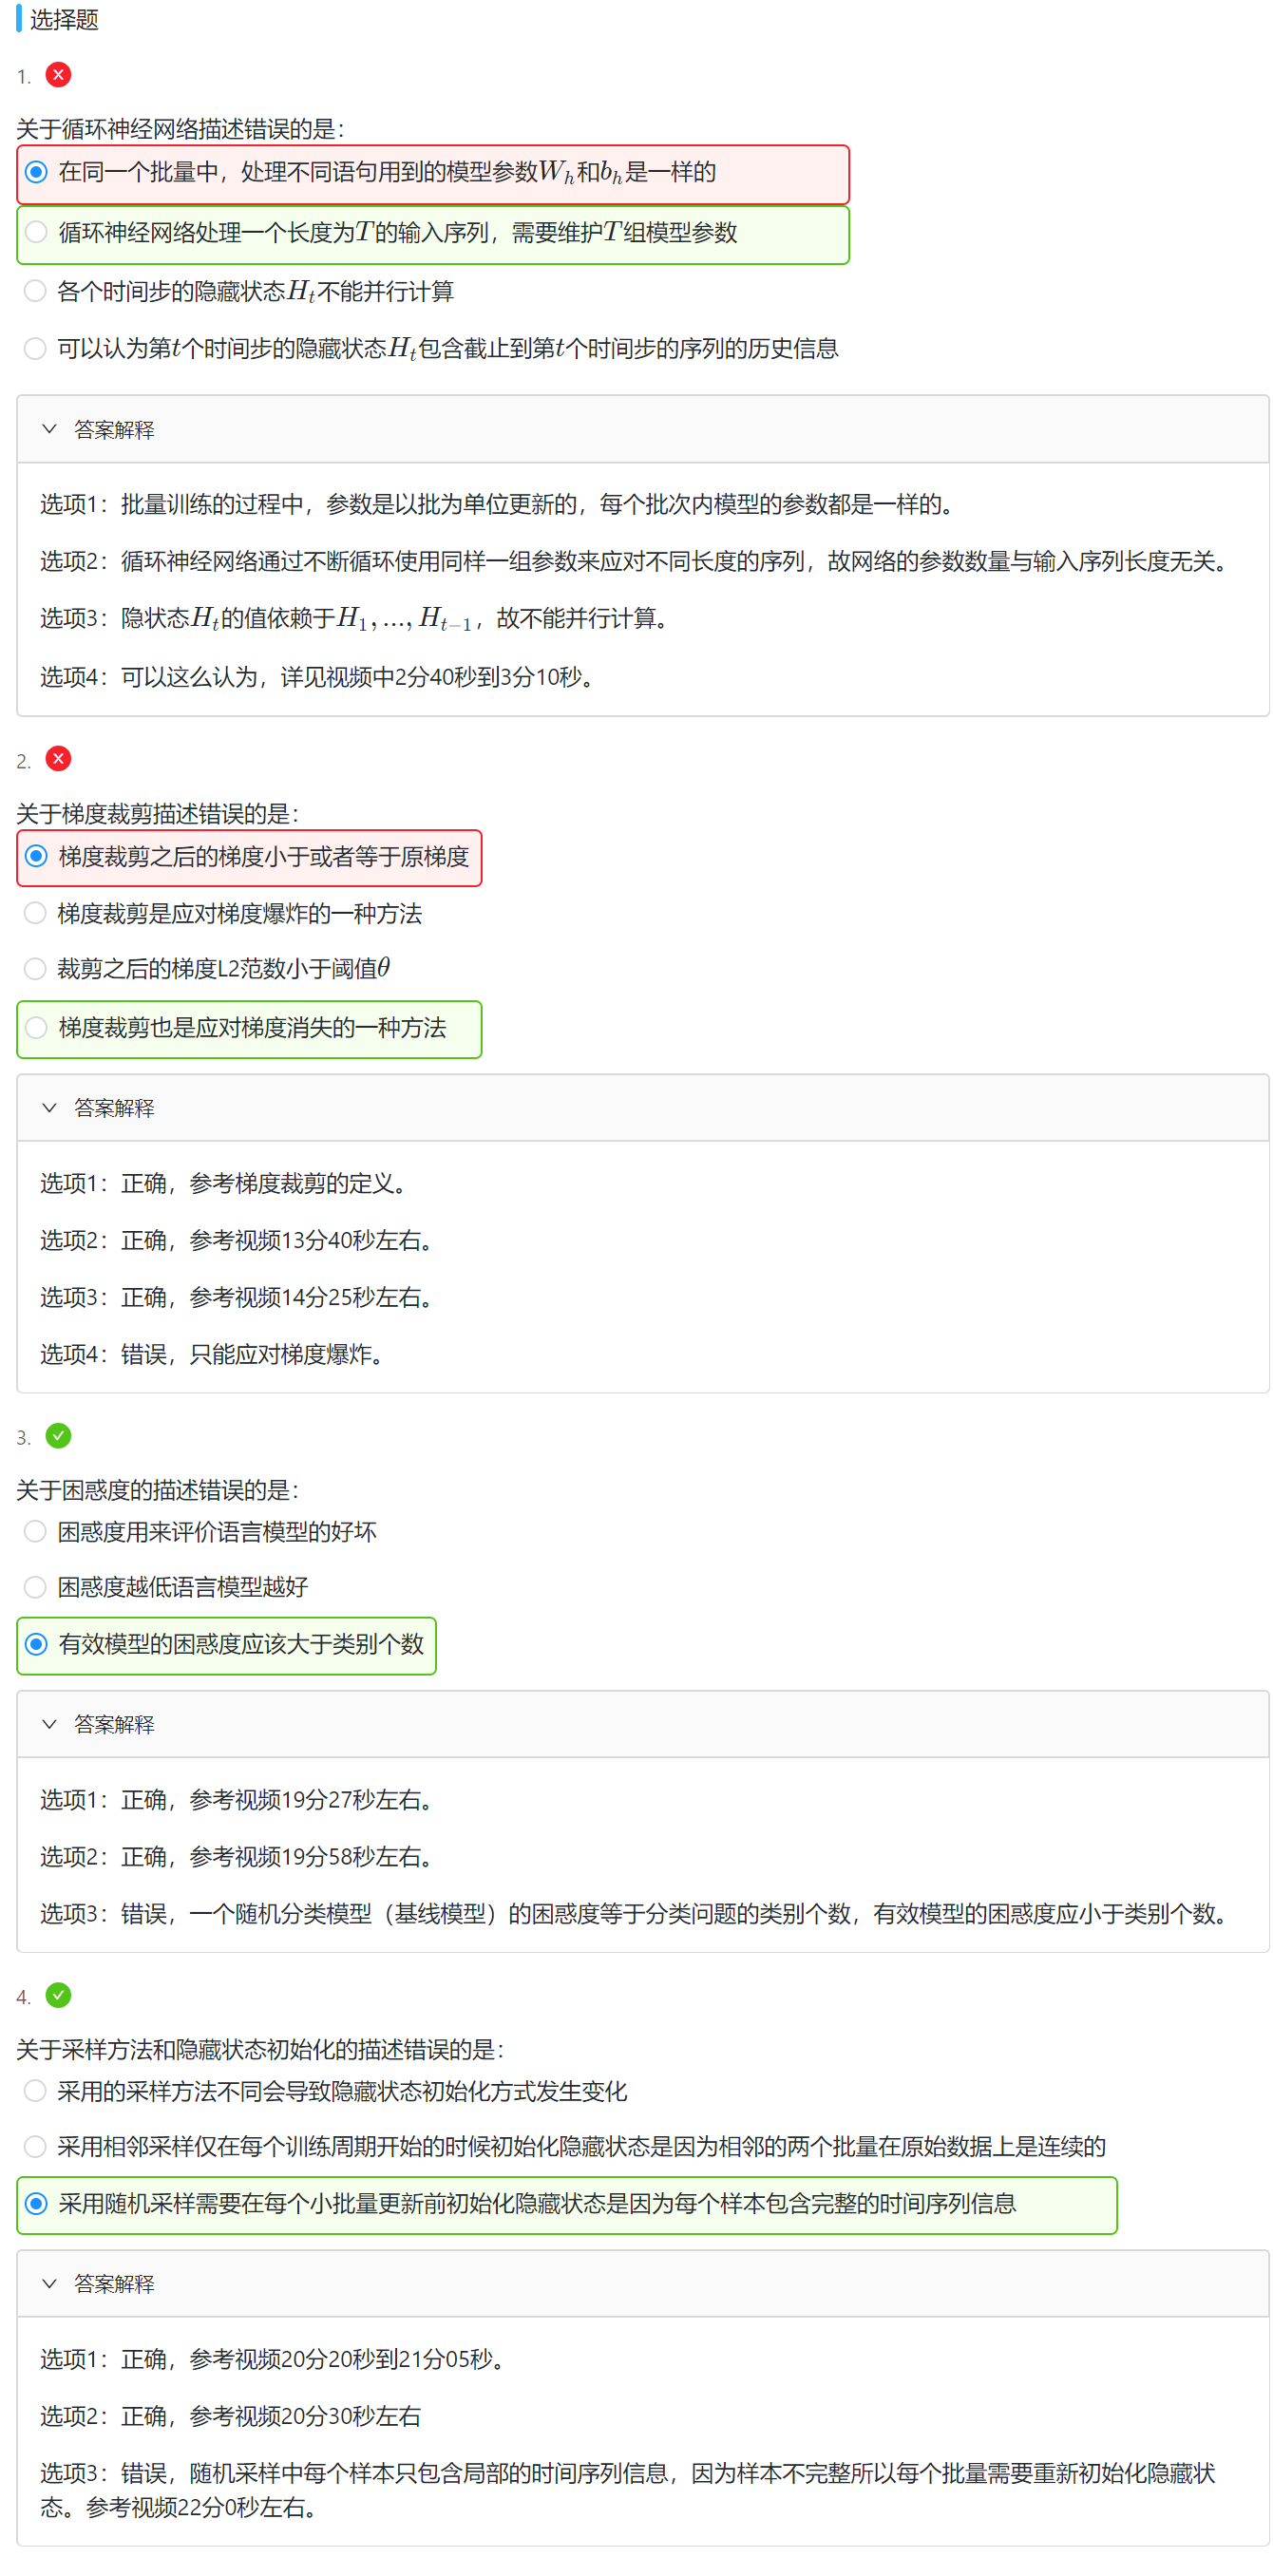